In [1]:
import re
import nltk
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
!python -m nltk.downloader stopwords wordnet punkt averaged_perceptron_tagger # remove if not running on colab
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.layers import Attention
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
!pip install rouge # remove if not running on colab
from rouge import Rouge

/usr/lib/python3.6/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Using TensorFlow backend.


### Hyperparameters

In [0]:
BATCH_SIZE=40
EPOCHS=30
LATENT_DIM=256
EMBEDDING_DIM=128
TEST_TRAIN_SPLIT=0.15
LEARNING_RATE=0.005
PATH=""
FILE_NAME="cnn-tr.csv"
MAX_TEXT_LEN = 250
MAX_SUMMARY_LEN = 20
UNCOMMON_WORD_THRESHOLD = 15
COLAB=True # true if running on colab
build_number="1"

In [0]:
# create rouge object for evaluation
rouge = Rouge()

## Data Processing

Read In Data

In [4]:
# Only needed if running on Google Colab
if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  PATH = "./drive/My Drive/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
df = pd.read_csv(PATH + FILE_NAME)
print(df.head())

   Unnamed: 0  ...                                            summary
0           0  ...          Young actor says plans fritter cash away 
1           1  ...     Leifman says system unjust hes fighting change
2           2  ...               Driver probably 30 35foot free fall 
3           3  ...  Five small polyps found procedure none worriso...
4           4  ...  Vick due federal court Monday future NFL remai...

[5 rows x 4 columns]


In [6]:
print(df.count)

<bound method DataFrame.count of       Unnamed: 0  ...                                            summary
0              0  ...          Young actor says plans fritter cash away 
1              1  ...     Leifman says system unjust hes fighting change
2              2  ...               Driver probably 30 35foot free fall 
3              3  ...  Five small polyps found procedure none worriso...
4              4  ...  Vick due federal court Monday future NFL remai...
...          ...  ...                                                ...
9995        9995  ...  Prosecutors said Siddiqui shot officers held A...
9996        9996  ...  Kansas banned K2 many states considering simil...
9997        9997  ...  Police say left scene alleged assault Manhatta...
9998        9998  ...  Judge described Thomas decent man devoted husband
9999        9999  ...  Industry says competitive bidding would reduce...

[10000 rows x 4 columns]>


Remove .'s that appear in stuff like U.S.A and U.N - Eventually need to move 
this to dataprocessing.py

In [7]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\..*$',' ',str(x)))
print(df['summary'][0])

Young actor says plans fritter cash away 
Young actor says plans fritter cash away 


In [8]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: re.sub(r'\.','',str(x)))
print(df['summary'][0])

Young actor says plans fritter cash away 
Young actor says plans fritter cash away 


Check for rows with null values in them, and copy these into a new dataframe (df1). Drop any rows in df1 from df to ensure no NaN valued rows are present

*Note. using simply dropna(how='any') does not seem to drop any of the rows*

In [9]:
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

True
(10000, 4)
(36, 4)
(9964, 4)
False


Word Count Distribution

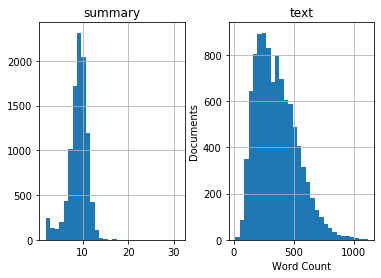

In [10]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
# plt.savefig('word_count_distro' + str(build_number) + '.png')
plt.show()

Cut down text to MAX_TEXT_LEN words, and summaries to MAX_SUMMARY_LEN

In [11]:
print(df['text'][0])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_TEXT_LEN]))
print(df['text'][0])

print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_SUMMARY_LEN]))
print(df['summary'][0])

LONDON England Reuters Harry Potter star Daniel Radcliffe gain access report 20 million 411 million fortune turn 18 Monday insists money wont cast spell Daniel Radcliffe Harry Potter Harry Potter Order Phoenix disappointment gossip columnist around world young actor say plan fritter cash away fast car drink celebrity party dont plan one people soon turn 18 suddenly buy massive sport car collection something similar told Australian interviewer earlier month dont think Ill particularly extravagant thing like buying thing cost 10 pound book CDs DVDs 18 Radcliffe able gamble casino buy drink pub see horror film Hostel Part II currently six place number one movie UK box office chart Details hell mark landmark birthday wrap agent publicist comment plan Ill definitely sort party say interview Hopefully none reading Radcliffes earnings first five Potter film held trust fund able touch Despite grow fame rich actor say keep foot firmly ground People always look say kid star go rail told reporter

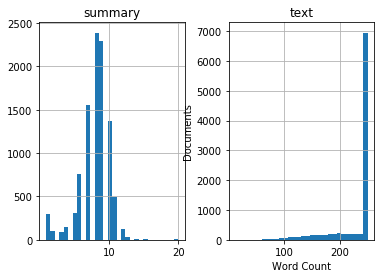

In [12]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')
# plt.savefig('word_count_distro_word_removal' + str(build_number) + '.png')
plt.show()

### Finding Uncommon Words and Removing Them.

Uncommon words are classified as those that occur in the whole corpus less times than UNCOMMON_WORD_THRESHOLD







#### Text

In [0]:
# x_word_dict = {}
# text = df['text'].apply(lambda x: nltk.word_tokenize(x))

# for index, row in text.iteritems():
#   for word in row:
#     if word not in x_word_dict.keys():
#       x_word_dict[word] = 1
#     else:
#       x_word_dict[word] += 1

# print(len(x_word_dict))
# # sort so that extracting acceptable words is more efficient for larger vocab sizes
# sorted_dict = sorted(x_word_dict.items(), key=lambda x: x[1], reverse=True)
# print(sorted_dict)
# x, y = zip(*sorted_dict)

In [0]:
# # find words that occur more than UNCOMMON_WORD_THRESHOLD times
# accept_words = []
# for word, occ in sorted_dict:
#   if int(occ) > UNCOMMON_WORD_THRESHOLD:
#     accept_words.append(word)
#   else:
#     break

# # remove uncommon words    
# accept_words = [x.lower() for x in accept_words]
# print(accept_words)
# print(df['text'][2])
# df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
# print(df['text'][2])


In [0]:
# x_word_dict_after = {}
# text = df['text'].apply(lambda x: nltk.word_tokenize(x))

# for index, row in text.iteritems():
#   for word in row:
#     if word not in x_word_dict_after.keys():
#       x_word_dict_after[word] = 1
#     else:
#       x_word_dict_after[word] += 1

# print(len(x_word_dict_after))

#### Summaries

In [0]:
# y_word_dict = {}
# summary = df['summary'].apply(lambda x: nltk.word_tokenize(x))

# for index, row in summary.iteritems():
#   for word in row:
#     if word not in y_word_dict.keys():
#       y_word_dict[word] = 1
#     else:
#       y_word_dict[word] += 1

# print(len(y_word_dict))
# sorted_dict = sorted(y_word_dict.items(), key=lambda x: x[1], reverse=True)
# print(sorted_dict)
# x, y = zip(*sorted_dict)

In [0]:
# accept_words = []
# for word, occ in sorted_dict:
#   if int(occ) > UNCOMMON_WORD_THRESHOLD:
#     accept_words.append(word)
#   else:
#     break
     
# accept_words = [x.lower() for x in accept_words]
# print(accept_words)
# print(df['summary'][2])
# df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if word.lower() in accept_words]))
# print(df['summary'][2])

In [0]:
# y_word_dict_after = {}
# summary = df['summary'].apply(lambda x: nltk.word_tokenize(x))

# for index, row in summary.iteritems():
#   for word in row:
#     if word not in y_word_dict_after.keys():
#       y_word_dict_after[word] = 1
#     else:
#       y_word_dict_after[word] += 1
# print(len(y_word_dict_after))

View Word Distribution after uncommon word removal

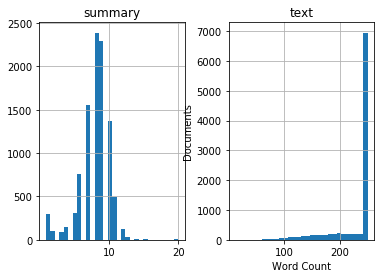

In [18]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in df['text']:
      text_word_count.append(len(i.split(' ')))

for i in df['summary']:
      summary_word_count.append(len(i.split(' ')))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.ylabel('Documents')
plt.xlabel('Word Count')

# plt.savefig('word_count_distro_word_removal' + str(build_number) + '.png')
plt.show()

### Update Max Text Lenths After Uncommon Word Removal & Drop Empty Rows

In [19]:
print(df['text'][0])
df['text'] = df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_TEXT_LEN]))
print(df['text'][0])

LONDON England Reuters Harry Potter star Daniel Radcliffe gain access report 20 million 411 million fortune turn 18 Monday insists money wont cast spell Daniel Radcliffe Harry Potter Harry Potter Order Phoenix disappointment gossip columnist around world young actor say plan fritter cash away fast car drink celebrity party dont plan one people soon turn 18 suddenly buy massive sport car collection something similar told Australian interviewer earlier month dont think Ill particularly extravagant thing like buying thing cost 10 pound book CDs DVDs 18 Radcliffe able gamble casino buy drink pub see horror film Hostel Part II currently six place number one movie UK box office chart Details hell mark landmark birthday wrap agent publicist comment plan Ill definitely sort party say interview Hopefully none reading Radcliffes earnings first five Potter film held trust fund able touch Despite grow fame rich actor say keep foot firmly ground People always look say kid star go rail told reporter

In [20]:
print(df['summary'][0])
df['summary'] = df['summary'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join(x[:MAX_SUMMARY_LEN]))
print(df['summary'][0])

Young actor says plans fritter cash away
Young actor says plans fritter cash away


In [21]:
# update max text lengths
MAX_TEXT_LEN = max([len(txt.split(' ')) for txt in df['text']])
MAX_SUMMARY_LEN = max([len(txt.split(' ')) for txt in df['summary']])
print(MAX_TEXT_LEN)
print(MAX_SUMMARY_LEN)

250
20


In [22]:
# drop any lines that have no text or summary after the word removal process
print(df.isnull().values.any())
print(df.shape)

df1 = df[df.isna().any(axis=1)]
print(df1.shape)

df.drop(df1.index, axis=0,inplace=True)
print(df.shape)
print(df.isnull().values.any())

False
(9964, 4)
(0, 4)
(9964, 4)
False


### Add in start and end tokens to summaries
This is necessary to ensure that the model can tell when each summaries start and end

In [23]:
df['summary'] = df['summary'].apply(lambda x : 'sostok '+ x + ' eostok')
print(df['summary'].head())

0    sostok Young actor says plans fritter cash awa...
1    sostok Leifman says system unjust hes fighting...
2    sostok Driver probably 30 35foot free fall eostok
3    sostok Five small polyps found procedure none ...
4    sostok Vick due federal court Monday future NF...
Name: summary, dtype: object


## Training-Validation Split

X - Articles text </br>
Y - Summaries

In [0]:
# convert to numpy array
X = np.array(df['text'])
Y = np.array(df['summary'])

In [25]:
x_tr,x_val,y_tr,y_val=train_test_split(X,Y,test_size=TEST_TRAIN_SPLIT,random_state=0,shuffle=True)
print(x_tr.shape)
print(x_val.shape)
print(y_tr.shape)
print(y_val.shape)

(8469,)
(1495,)
(8469,)
(1495,)


## Word Embeddings - Tokenization

X Tokenizer

In [26]:
word_dict = {}
text = df['text']

for row in text: 
  for word in row.split(" "):
    if word not in word_dict:
      word_dict[word] = 1
    else:
      word_dict[word] += 1

print(len(word_dict))

82455


In [27]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=len(word_dict), split=" ") 
x_tokenizer.fit_on_texts(list(X))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=MAX_TEXT_LEN, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=MAX_TEXT_LEN, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1
print(x_voc)

82456


In [0]:
with open('xtokenizer.pickle', 'wb') as handle:
  pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

Y Tokenizer

In [29]:
y_word_dict = {}
summ = df['summary']

for row in summ: 
  for word in row.split(" "):
    if word not in y_word_dict:
      y_word_dict[word] = 1
    else:
      y_word_dict[word] += 1

print(len(y_word_dict))

16372


In [30]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=len(y_word_dict), split=" ") 
y_tokenizer.fit_on_texts(list(Y))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=MAX_SUMMARY_LEN, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=MAX_SUMMARY_LEN, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words + 1
print(y_voc)
print(y_tokenizer.word_counts['sostok'],len(y_tr))

16373
9964 8469


In [0]:
with open('ytokenizer.pickle', 'wb') as handle:
  pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Learning Model

#### Encoder Model

In [32]:
#encoder input
encoder_inputs = Input(shape=(MAX_TEXT_LEN,))
#embedding layer
enc_emb =  Embedding(x_voc,EMBEDDING_DIM,trainable=True)(encoder_inputs)
# bidirectional encoder lstm 
encoder_lstm = Bidirectional(LSTM(LATENT_DIM,return_sequences=True,return_state=True))
# outputs and encoder final states
encoder_outputs, fw_state_h, fw_state_c, bw_state_h, bw_state_c = encoder_lstm(enc_emb)

state_h = Concatenate()([fw_state_h, bw_state_h])
state_c = Concatenate()([fw_state_c, bw_state_c])
encoder_states = [state_h, state_c]

#### Decoder Model

In [0]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, EMBEDDING_DIM,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(LATENT_DIM*2, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=encoder_states)
                                                          
#dense layer 
#soft max creates a prob vector that allows us to determine the final output
decoder_dense = Dense(y_voc, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)


#### Combined LSTM Model

In [34]:
# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 250, 128)     10554368    input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 250, 512), ( 788480      embedding_1[0][0]                
____________________________________________________________________________________________

In [0]:
optimizer = RMSprop(lr=LEARNING_RATE, rho=0.9)

In [36]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy')

- Early Stopping Callback to ensure we stop when Validation Loss is lowest - minimises risk of overfitting
- Model Checkpoint saves the model after each epoch so that we can load the model with the best weights later on. Alternatively, it allows us to continue training the model at a later data



In [0]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2, restore_best_weights=False)
filepath = "./model/saved-model-{epoch:02d}.hdf5"
if COLAB:
  filepath = PATH + "project-model/saved-model-{epoch:02d}.hdf5"
mc = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#### Use this  to train a new model. To continue training a previously trained model see below

In [0]:
# reshape y from two dimensions to three dimensions
y_tr_3d = y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:]
y_val_3d = y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]

In [39]:
print(x_tr.shape)
print(y_tr.shape)
print(y_tr_3d.shape)
print(x_val.shape)
print(y_val.shape)
print(y_val_3d.shape)

(8469, 250)
(8469, 20)
(8469, 19, 1)
(1495, 250)
(1495, 20)
(1495, 19, 1)


In [40]:
history = model.fit([x_tr,y_tr[:,:-1]], y_tr_3d, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[es,mc], validation_data=([x_val,y_val[:,:-1]], y_val_3d))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 8469 samples, validate on 1495 samples
Epoch 1/30





8469/8469 [==============================] - 208s 25ms/step - loss: 3.9722 - val_loss: 3.6724
Epoch 2/30
8469/8469 [==============================] - 196s 23ms/step - loss: 3.5083 - val_loss: 3.6163
Epoch 3/30
8469/8469 [==============================] - 196s 23ms/step - loss: 3.3120 - val_loss: 3.6390
Epoch 4/30
8469/8469 [==============================] - 197s 23ms/step - loss: 3.0964 - val_loss: 3.6049
Epoch 5/30
8469/8469 [==============================] - 197s 23ms/step - loss: 2.8181 - val_loss: 3.6212
Epoch 6/30
8469/8469 [==============================] - 197s 23ms/step - loss: 2.5274 - val_loss: 3.6466
Epoch 00006: early stopping


#### This method is to only be used when loading a previously partially trained model

In [0]:
# model = load_model("./drive/My Drive/project-model/saved-model-53.hdf5")
# history = model.fit([x_tr,y_tr[:,:-1]], y_tr, callbacks=[mc], batch_size=BATCH_SIZE, epochs=1, validation_data=([x_val,y_val[:,:-1]], y_val))

### Plot training and validation loss overtime

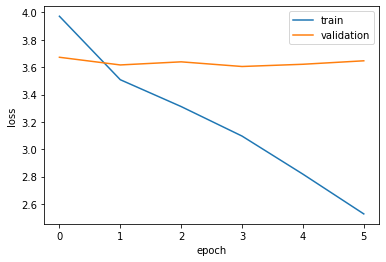

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
# plt.savefig('loss' + str(build_number) + '.png')
plt.show()

## Inference Model

In [0]:
# load model from drive
# model = load_model("./drive/My Drive/saved-model-53.hdf5")

In [44]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
print(reverse_source_word_index)
print(reverse_target_word_index)
# used to get positions of sostok and eostok
target_word_index=y_tokenizer.word_index

{1: 'say', 2: 'one', 3: 'year', 4: 'people', 5: 'us', 6: 'new', 7: 'make', 8: 'take', 9: 'two', 10: 'go', 11: 'would', 12: 'time', 13: 'also', 14: 'told', 15: 'get', 16: 'police', 17: 'report', 18: 'president', 19: 'first', 20: 'day', 21: 'last', 22: 'cnn', 23: 'government', 24: 'come', 25: 'know', 26: 'country', 27: 'like', 28: 'world', 29: 'work', 30: 'call', 31: 'official', 32: 'watch', 33: 'see', 34: 'show', 35: 'accord', 36: 'could', 37: 'state', 38: 'family', 39: 'home', 40: 'week', 41: 'child', 42: 'use', 43: 'include', 44: 'united', 45: 'obama', 46: 'kill', 47: 'many', 48: 'want', 49: 'three', 50: 'life', 51: 'city', 52: 'give', 53: 'found', 54: 'woman', 55: 'month', 56: 'well', 57: 'group', 58: 'million', 59: 'house', 60: 'help', 61: 'think', 62: 'since', 63: 'force', 64: 'back', 65: 'attack', 66: 'statement', 67: 'way', 68: 'even', 69: 'may', 70: 'military', 71: 'right', 72: 'case', 73: 'charge', 74: 'look', 75: 'tuesday', 76: 'death', 77: 'states', 78: 'court', 79: 'wednesda

In [0]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

In [46]:
encoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 250, 128)     10554368    input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 250, 512), ( 788480      embedding_1[0][0]                
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 512)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][3]      

In [0]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(LATENT_DIM*2,))
decoder_state_input_c = Input(shape=(LATENT_DIM*2,))
decoder_hidden_state_input = Input(shape=(MAX_TEXT_LEN,LATENT_DIM*2))
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_state_inputs)
decoder_states = [state_h2, state_c2]
# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + decoder_states)

In [48]:
decoder_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 128)    2095744     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 512)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 512)          0                                            
____________________________________________________________________________________________

### Methods for Reversing Word Embeddings

In [0]:
def seq_to_text(input_seq, summary):       
  textString=''
  if not summary:
      for i in input_seq:
          if(i!=0):
              textString = textString + ' ' + reverse_source_word_index[i]
  else:
      for i in input_seq:
          if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
              textString = textString + ' ' + reverse_target_word_index[i]
  return textString 

### Summarisation Method 

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (MAX_SUMMARY_LEN-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

## Test Model Output

In [0]:
def getRouge(gt, pred):
  return rouge.get_scores(pred, gt)

In [52]:
for i in range(0,10):
    print("----------------------")
    article = seq_to_text(x_tr[i], False)
    original = seq_to_text(y_tr[i], True)

    if (original !=""):
      print("Article: " + article)
      print("Original summary:", original)
      # reshape data into correct format for encoder (1, max_text_len)
      x_tr_i_reshaped = x_tr[i].reshape(1,MAX_TEXT_LEN)
      summary = decode_sequence(x_tr_i_reshaped)
      print("Generated summary:",summary)
      print("\n")

      if summary != "":    
          print("ROUGE score: ")
          score = getRouge(str(summary), str(original))
          print(score)
          print(score[0].get('rouge-1').get('f'))
          print(score[0].get('rouge-1').get('p'))
          print(score[0].get('rouge-1').get('r'))

----------------------
Article:  london england 80 million research project aim give people 50 active year age 50 launch scientist university leeds northern england tuesday challenge ensure old people stay fit brisbane centenarian ruth frith see compete shot put world masters games sydney month half baby born western country today live 100 year old accord recent research publish medical journal lancet challenge ensure remain active throughout old age us live longer parent grandparent age population mean come decade people suffer agerelated condition osteoarthritis heart disease chronic back pain obesity increase physical activity also put pressure joint cause wear faster scientists leeds university envisage many body part flounder age could upgraded use owngrown tissue durable implant mean artificial hip knee heart valve example last far longer current 20year typical lifespan work driven concept 50 year 50 make second 50 year life healthy comfortable active first enjoy high quality lif

In [53]:
for i in range(1243,1253):
    print("----------------------")
    article = seq_to_text(x_tr[i], False)
    original = seq_to_text(y_tr[i], True)

    if (original !=""):
      print("Article: " + article)
      print("Original summary:", original)
      # reshape data into correct format for encoder (1, max_text_len)
      x_tr_i_reshaped = x_tr[i].reshape(1,MAX_TEXT_LEN)
      summary = decode_sequence(x_tr_i_reshaped)
      print("Generated summary:",summary)
      print("\n")

      if summary != "":    
          print("ROUGE score: ")
          score = getRouge(str(summary), str(original))
          print(score)
          print(score[0].get('rouge-1').get('f'))
          print(score[0].get('rouge-1').get('p'))
          print(score[0].get('rouge-1').get('r'))

----------------------
Article:  sens john mccain barack obama engage point exchange al qaeda iraq wednesday sen john mccain question sen barack obamas way handle war iraq mccain question whether obama aware al qaeda base obamas response thing al qaeda iraq george bush john mccain decide invade iraq mccain tyler texas obama columbus ohio understand sen obama say al qaeda establish base iraq would send troop back militarily al qaeda already base iraq call al qaeda iraq mccain say remarkable statement say would send troop back place al qaeda establish base already establish base mccains comment come response remark obama make tuesday night debate sen hillary clinton ask president would right go back iraq order suppress insurrection downsize us troop presence watch clinton obama say war always reserve right president make sure look american interest obama say al qaeda form base iraq act way secures american homeland interest abroad statement mccains press office wednesday say sen obama un

## Evaluation

Using ROUGE (Recall-Orientated Understanding Gisting Evaluation) to evaluate the generated summaries.

*Note: This takes a long time, especially with large datasets* 

### For Training Data

In [54]:
print(len(x_tr))

8469


In [55]:
tr_target_summary = []
tr_generated_summary = []
x_tr_len = len(x_tr)

f_ov = 0
p_ov = 0
r_ov = 0
# x_val_len = 1
for i in range(0,x_tr_len):
  print(i)
  original = seq_to_text(y_tr[i], True)
  if original != "" :
      tr_target_summary.append(original)
      x_i = x_tr[i].reshape(1,MAX_TEXT_LEN)
      summary = decode_sequence(x_i)
      print(i)
      print(original)
      print(summary)
      print("-----")
      tr_generated_summary.append(summary)
      score = getRouge(str(summary), str(original))
      f_ov += float(score[0].get('rouge-1').get('f'))
      p_ov += float(score[0].get('rouge-1').get('p'))
      r_ov += float(score[0].get('rouge-1').get('r'))

Streaming output truncated to the last 5000 lines.
7469
 bodies six italian soldiers died returned italy sunday
 attack comes day three deadly attacks lahore peshawar peshawar
-----
7470
7470
 the cliff diver splish splash long island drop daredevils eight stories
 the best score amateur city at
-----
7471
7471
 british government imposed export ban ade651 tests showed suitable bomb detection
 uk police believe man arrested saturday gang million children
-----
7472
7472
 wfp warns situation get worse unless shortfalls resources addressed
 new york says new york police say may kids may make make make make make make make make make
-----
7473
7473
 hamilton remembers thrill old hollywood one day gone
 the york city city last week life made life
-----
7474
7474
 book muddied comes wants scream
 the show show top 10 million people
-----
7475
7475
 collection letters benjamin franklin found london
 the new york says new york could make new york could help toll reduce reduce images
-----
7476

In [56]:
print("Avg F Score: " + str(f_ov/x_tr_len))
print("Avg Precision: " + str(p_ov/x_tr_len))
print("Avg Recall: " + str(r_ov/x_tr_len))

Avg F Score: 0.06807304818118808
Avg Precision: 0.06642689187853894
Avg Recall: 0.07670151249676575


### For Validation Data

In [57]:
val_target_summary = []
val_generated_summary = []
x_val_len = len(x_val)

f_ov = 0
p_ov = 0
r_ov = 0
# x_val_len = 1
for i in range(0,x_val_len):
  print(i)
  original = seq_to_text(y_val[i], True)
  if original != "" :
      val_target_summary.append(original)
      x_i = x_val[i].reshape(1,MAX_TEXT_LEN)
      summary = decode_sequence(x_i)
      print(i)
      print(original)
      print(summary)
      print("-----")
      val_generated_summary.append(summary)
      score = getRouge(str(summary), str(original))
      f_ov += float(score[0].get('rouge-1').get('f'))
      p_ov += float(score[0].get('rouge-1').get('p'))
      r_ov += float(score[0].get('rouge-1').get('r'))

Streaming output truncated to the last 5000 lines.
495
 affidavit dr
 she hopes open doors students study want
-----
496
496
 cycle life features 200 human bodies various life stages
 she says four leaders use use face role house side side
-----
497
497
 the full scientific program lhc wil probably last 20 years
 the new building show anything says new york city
-----
498
498
 he says changes wont kill grandma medicare cover less cost
 the u
-----
499
499
 station informed listeners people need food rescue
 they believe two kids accused sail make carolina island
-----
500
500
 iranian conservatives say captured seats parliamentary election
 u
-----
501
501
 millions homes businesses expected join event
 the couple could help 25 years prison
-----
502
502
 expert says tigers transgressions impact sponsorship may open new avenues
 the swiss world one one new one two weeks
-----
503
503
 strong winds rain powerful storm left thousands without power
 police say man accused arrested killing

In [58]:
print("Avg F Score: " + str(f_ov/x_val_len))
print("Avg Precision: " + str(p_ov/x_val_len))
print("Avg Recall: " + str(r_ov/x_val_len))

Avg F Score: 0.03480238083014209
Avg Precision: 0.035701455734900654
Avg Recall: 0.04143192556236042


# Inputting New Data

In [0]:
def getpos(word):
  pos = nltk.pos_tag([word])[0][1][0]
  wordnet_conv = {"J": wn.ADJ, "N": wn.NOUN, "V": wn.VERB, "R": wn.ADV}
  if pos in wordnet_conv.keys():
    return wordnet_conv.get(pos)
  return ""

In [0]:
def lemmatization(text):
  lemmatizer = WordNetLemmatizer()
  text_tokenized = inp_df['text'].apply(lambda x: nltk.word_tokenize(x))
  print("lemmatize with pos")
  for i in range(0,len(text_tokenized)):
    text_lemmatized = []
    for word in text_tokenized[i]:
      pos = getpos(word)
      if pos != "":
        lemma = lemmatizer.lemmatize(word, pos)
        text_lemmatized.append(lemma)
      else :
        text_lemmatized.append(word)
    text_lemmatized = ' '.join(map(str, text_lemmatized))
    inp_df['text'][i] = text_lemmatized


In [61]:
input1 = "(CNN) — Earlier this year, Delta Air Lines announced a rethink on reclining seats. In an effort to disrupt fewer passengers' travel experiences, Delta said it'd begin revamping some of its jets to reduce the recline of coach seats from four inches to two inches and the recline of first class seats from 5.5 inches to 3.5 inches. For those who abhor the recline option, it's a small step. And for those who value it, well, it's a compromise. This seemingly innocuous topic is one where there are very much two minds on what's acceptable and what's not. Two CNN Travel staffers engage in a friendly debate about seat recline. Your seat. Your decision. Stacey Lastoe, senior editor at CNN Travel, is of above-average height and makes no apology about reclining; it's her right as a plane, train and bus passenger. She encourages the person sitting in front of her to recline as well. On the first leg of my flight to Japan for my honeymoon, my husband and I got upgraded to first class. Although it would just be a few hours in the sky en route to Dallas, I was excited about sipping Champagne, sitting back and relaxing. Flute in hand, I pushed back to recline my seat for maximum relaxation. But it would not budge; I appeared to be stuck in a dysfunctional seat. Or was I? Turns out the gentleman behind me had a dog in a crate down between his legs, positioned so the seat in front of his -- my seat -- had nowhere to go. Because we were newlyweds and loving every moment of it, I did not mind when my husband turned to the man and told him his wife wanted to recline her seat and asked if he could please rearrange his dog crate to allow for everyones comfort."
# input1 = "Its official US President Barack Obama want lawmaker weigh whether use military force Syria Obama sent letter head House Senate Saturday night hour announce believe military action Syrian target right step take allege use chemical weapon The propose legislation Obama asks Congress approve use military force deter disrupt prevent degrade potential future us chemical weapon weapon mass destruction Its step set turn international crisis fierce domestic political battle There key question loom debate What UN weapon inspector find Syria What happens Congress vote And Syrian government react In televise address White House Rose Garden earlier Saturday president say would take case Congress want While I believe I authority carry military action without specific congressional authorization I know country strong take course action even effective say We debate issue big business usual Obama say top congressional leader agree schedule debate body return Washington September 9 The Senate Foreign Relations Committee hold hearing matter Tuesday Sen Robert Menendez say Transcript Read Obamas full remark Syrian crisis Latest development UN inspector leave Syria Obamas remark come shortly UN inspector left Syria carry evidence determine whether chemical weapon use attack early last week Damascus suburb The aim game mandate clear ascertain whether chemical weapon use UN spokesman Martin Nesirky told reporter Saturday But use weapon report toxic gas attack Damascus suburb August 21 key point global debate Syrian crisis Top US official say there doubt Syrian government behind Syrian official deny responsibility blame jihadist fight rebel British US intelligence report say attack involve chemical weapon UN official stress importance wait official report inspector The inspector share finding UN SecretaryGeneral Ban Kimoon Ban say want wait UN team final report complete present UN Security Council The Organization Prohibition Chemical Weapons nine inspector belong say Saturday could take three week analyze evidence collect It need time able analyze information sample Nesirky say He note Ban repeatedly say alternative political solution crisis Syria military solution option Bergen Syria problem hell US Obama This menace must confront Obamas senior adviser debate next step take president comment Saturday come amid mount political pressure situation Syria Some US lawmaker call immediate action others warn step could become quagmire Some global leader express support British Parliaments vote military action earlier week blow Obamas hope get strong backing key NATO ally On Saturday Obama propose say would limited military action Syrian President Bashar alAssad Any military attack would openended include US ground force say Syrias allege use chemical weapon earlier month assault human dignity president say A failure respond force Obama argue could lead escalate use chemical weapon proliferation terrorist group would people harm In world many danger menace must confront Syria missile strike What would happen next Map US allied asset around Syria Obama decision come Friday night On Friday night president make lastminute decision consult lawmaker What happen vote Its unclear A senior administration official told CNN Obama authority act without Congress even Congress reject request authorization use force Obama Saturday continued shore support strike alAssad government He spoke phone French President Francois Hollande Rose Garden speech The two leader agree international community must deliver resolute message Assad regime others would consider use chemical weapon crime unacceptable violate international norm held accountable world White House say Meanwhile uncertainty loom Congress would weigh US military official say remain ready 5 key assertion US intelligence report Syria Syria Who want chemical weapon horror Reactions mixed Obamas speech A spokesman Syrian National Coalition say opposition group disappointed Obamas announcement Our fear lack action could embolden regime repeat attack serious way say spokesman Louay Safi So quite concerned Some member Congress applaud Obamas decision House Speaker John Boehner Majority Leader Eric Cantor Majority Whip Kevin McCarthy Conference Chair Cathy McMorris Rodgers issue statement Saturday praise president Under Constitution responsibility declare war lie Congress Republican lawmaker say We glad president seek authorization military action Syria response serious substantive question raise More 160 legislator include 63 Obamas fellow Democrats sign letter call either vote least full debate US action British Prime Minister David Cameron whose attempt get lawmaker country support military action Syria fail earlier week respond Obamas speech Twitter post Saturday I understand support Barack Obamas position Syria Cameron say An influential lawmaker Russia stood Syria criticize United States theory The main reason Obama turn Congress military operation get enough support either world among ally US United States Alexei Pushkov chairman internationalaffairs committee Russian State Duma say Twitter post In United States scatter group antiwar protester around country take street Saturday Like many Americanswere tire United States get involve invade bombing country say Robin Rosecrans among hundred Los Angeles demonstration What Syrias neighbor think Why Russia China Iran stand Assad Syrias government unfazed After Obamas speech military political analyst Syrian state TV say Obama embarrass Russia opposes military action Syria cry help someone come rescue face two defeat political military level Syrias prime minister appear unfazed saberrattling The Syrian Armys status maximum readiness finger trigger confront challenge Wael Nader alHalqi say meeting delegation Syrian expatriate Italy accord banner Syria State TV broadcast prior Obamas address An anchor Syrian state television say Obama appear prepare aggression Syria base repeat lie A top Syrian diplomat told state television network Obama face pressure take military action Israel Turkey Arabs rightwing extremist United States I think do well Cameron term take issue Parliament say Bashar Jaafari Syrias ambassador United Nations Both Obama Cameron say climbed top tree dont know get The Syrian government deny use chemical weapon August 21 attack say jihadist fight rebel use effort turn global sentiment British intelligence put number people kill attack 350 On Saturday Obama say told well 1000 people murder US Secretary State John Kerry Friday cite death toll 1429 400 child No explanation offer discrepancy Iran US military action Syria would spark disaster Opinion Why strike Syria bad idea"
inp_df = pd.DataFrame(columns=['text', 'summary'])
inp_df = inp_df.append({'text': str(input1), 'summary': ""}, ignore_index=True)
inp_df.head()

,text,summary
0,"(CNN) — Earlier this year, Delta Air Lines ann...",


In [0]:
inp_df['text'] = inp_df['text'].apply(lambda x: re.sub(r'\(CNN\)|--|[^\w\s\.]','',x)).apply(lambda x: re.sub(r'(\.(?=[\s\r\n]|$))','',x)).apply(lambda x: re.sub(r'\n',' ',x)).apply(lambda x: re.sub(r'\.','',x))

In [0]:
# remove stop words
stop_words = set(stopwords.words('english'))
inp_df['text'] = inp_df['text'].apply(lambda x: nltk.word_tokenize(x)).apply(lambda x: " ".join([word for word in x if not word in stop_words]))

In [64]:
#lemmatize
lemmatization(inp_df['text'])
print(inp_df['text'])

lemmatize with pos
0    Earlier year Delta Air Lines announce rethink ...
Name: text, dtype: object


In [65]:
seq = np.array(inp_df['text'])
print(seq)

['Earlier year Delta Air Lines announce rethink recline seat In effort disrupt few passenger travel experience Delta say itd begin revamp jet reduce recline coach seat four inch two inch recline first class seat 55 inch 35 inch For abhor recline option small step And value well compromise This seemingly innocuous topic one much two mind whats acceptable whats Two CNN Travel staffer engage friendly debate seat recline Your seat Your decision Stacey Lastoe senior editor CNN Travel aboveaverage height make apology recline right plane train bus passenger She encourages person sit front recline well On first leg flight Japan honeymoon husband I get upgraded first class Although would hour sky en route Dallas I excite sip Champagne sit back relax Flute hand I push back recline seat maximum relaxation But would budge I appear stuck dysfunctional seat Or I Turns gentleman behind dog crate leg position seat front seat nowhere go Because newlywed love every moment I mind husband turn man told wi

In [66]:
seq_tokenizer = x_tokenizer.texts_to_sequences(seq)
#padding zero upto maximum length
seq_tokenizer_padded = pad_sequences(seq_tokenizer,  maxlen=MAX_TEXT_LEN, padding='post')
gen_summary = decode_sequence(seq_tokenizer_padded)
original_txt = ' '.join(seq)

print("---")
print("Original: " + original_txt)
print("Generated Summary: " + gen_summary)
# this will probs fail
print("ROUGE score: ")
print(getRouge(summary, original_txt))

---
Original: Earlier year Delta Air Lines announce rethink recline seat In effort disrupt few passenger travel experience Delta say itd begin revamp jet reduce recline coach seat four inch two inch recline first class seat 55 inch 35 inch For abhor recline option small step And value well compromise This seemingly innocuous topic one much two mind whats acceptable whats Two CNN Travel staffer engage friendly debate seat recline Your seat Your decision Stacey Lastoe senior editor CNN Travel aboveaverage height make apology recline right plane train bus passenger She encourages person sit front recline well On first leg flight Japan honeymoon husband I get upgraded first class Although would hour sky en route Dallas I excite sip Champagne sit back relax Flute hand I push back recline seat maximum relaxation But would budge I appear stuck dysfunctional seat Or I Turns gentleman behind dog crate leg position seat front seat nowhere go Because newlywed love every moment I mind husband turn